Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [75]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [76]:
pickle_file = 'all_data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [77]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [78]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [50]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                         ) + beta_regul * tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [51]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.01}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 48.788288
Minibatch accuracy: 14.1%
Validation accuracy: 16.4%
Minibatch loss at step 500: 0.757698
Minibatch accuracy: 85.9%
Validation accuracy: 80.9%
Minibatch loss at step 1000: 0.798442
Minibatch accuracy: 78.9%
Validation accuracy: 80.8%
Minibatch loss at step 1500: 0.554608
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.651663
Minibatch accuracy: 88.3%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 0.676383
Minibatch accuracy: 82.8%
Validation accuracy: 80.5%
Minibatch loss at step 3000: 0.805645
Minibatch accuracy: 80.5%
Validation accuracy: 81.3%
Test accuracy: 88.5%


The L2 regularization introduces a new meta parameter that should be tuned. Since I do not have any idea of what should be the right value for this meta parameter, I will plot the accuracy by the meta parameter value (in a logarithmic scale)

In [36]:
regul_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for beta in regul_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized for reg = {0}".format(beta))
        for step in range(num_steps):
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized for reg = 0.0001
Initialized for reg = 0.00012589254117941674
Initialized for reg = 0.00015848931924611142
Initialized for reg = 0.0001995262314968881
Initialized for reg = 0.0002511886431509582
Initialized for reg = 0.00031622776601683826
Initialized for reg = 0.00039810717055349773
Initialized for reg = 0.000501187233627273
Initialized for reg = 0.0006309573444801943
Initialized for reg = 0.0007943282347242829
Initialized for reg = 0.001000000000000002
Initialized for reg = 0.00125892541179417
Initialized for reg = 0.0015848931924611173
Initialized for reg = 0.001995262314968885
Initialized for reg = 0.0025118864315095872
Initialized for reg = 0.003162277660168389
Initialized for reg = 0.0039810717055349856
Initialized for reg = 0.00501187233627274
Initialized for reg = 0.006309573444801955
Initialized for reg = 0.007943282347242847


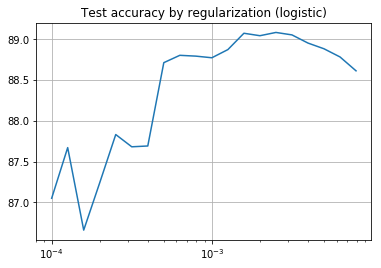

In [40]:
plt.semilogx(regul_values, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

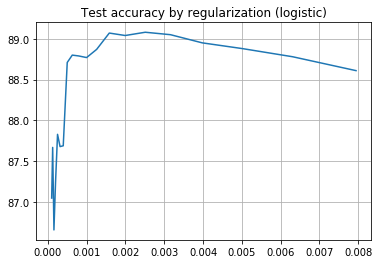

In [41]:
plt.plot(regul_values, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Let's see if the same technique will improve the prediction of the 1-layer neural network:

In [55]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables.
    hidden_layer_size = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]))
    
    hidden_logits = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(hidden_logits, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+ \
      beta_regul * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_valid_weights = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid_weights, weights) + biases)
    hidden_test_weights = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test_weights, weights) + biases)

In [56]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.001 }
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 687.077759
Minibatch accuracy: 13.3%
Validation accuracy: 39.4%
Minibatch loss at step 500: 198.096100
Minibatch accuracy: 82.0%
Validation accuracy: 77.9%
Minibatch loss at step 1000: 114.316017
Minibatch accuracy: 82.0%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 68.082321
Minibatch accuracy: 89.1%
Validation accuracy: 83.0%
Minibatch loss at step 2000: 41.085484
Minibatch accuracy: 89.8%
Validation accuracy: 84.6%
Minibatch loss at step 2500: 25.023912
Minibatch accuracy: 91.4%
Validation accuracy: 85.6%
Minibatch loss at step 3000: 15.451547
Minibatch accuracy: 85.9%
Validation accuracy: 86.4%
Test accuracy: 93.2%


In [57]:
regul_values = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for beta in regul_values:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized for reg = {0}".format(beta))
        for step in range(num_steps):
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized for reg = 0.0001
Initialized for reg = 0.00012589254117941674
Initialized for reg = 0.00015848931924611142
Initialized for reg = 0.0001995262314968881
Initialized for reg = 0.0002511886431509582
Initialized for reg = 0.00031622776601683826
Initialized for reg = 0.00039810717055349773
Initialized for reg = 0.000501187233627273
Initialized for reg = 0.0006309573444801943
Initialized for reg = 0.0007943282347242829
Initialized for reg = 0.001000000000000002
Initialized for reg = 0.00125892541179417
Initialized for reg = 0.0015848931924611173
Initialized for reg = 0.001995262314968885
Initialized for reg = 0.0025118864315095872
Initialized for reg = 0.003162277660168389
Initialized for reg = 0.0039810717055349856
Initialized for reg = 0.00501187233627274
Initialized for reg = 0.006309573444801955
Initialized for reg = 0.007943282347242847


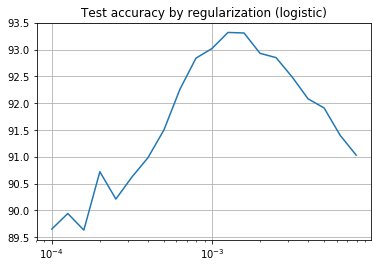

In [58]:
plt.semilogx(regul_values, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [64]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [65]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 297.189026
Minibatch accuracy: 10.2%
Validation accuracy: 34.0%
Minibatch loss at step 2: 1732.683350
Minibatch accuracy: 34.4%
Validation accuracy: 41.1%
Minibatch loss at step 4: 228.338791
Minibatch accuracy: 60.2%
Validation accuracy: 62.3%
Minibatch loss at step 6: 90.182762
Minibatch accuracy: 70.3%
Validation accuracy: 64.5%
Minibatch loss at step 8: 41.099766
Minibatch accuracy: 82.8%
Validation accuracy: 70.8%
Minibatch loss at step 10: 39.506241
Minibatch accuracy: 88.3%
Validation accuracy: 72.8%
Minibatch loss at step 12: 21.438553
Minibatch accuracy: 93.0%
Validation accuracy: 73.6%
Minibatch loss at step 14: 5.870131
Minibatch accuracy: 94.5%
Validation accuracy: 73.3%
Minibatch loss at step 16: 2.230348
Minibatch accuracy: 98.4%
Validation accuracy: 73.2%
Minibatch loss at step 18: 6.779141
Minibatch accuracy: 97.7%
Validation accuracy: 73.7%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.7%
Mi

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [68]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    hidden_layer_size = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]))
    
    hidden_logits = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
    
    drop1 = tf.nn.dropout(hidden_logits, 0.5)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(drop1, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_valid_weights = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid_weights, weights) + biases)
    hidden_test_weights = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test_weights, weights) + biases)

In [69]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 559.147217
Minibatch accuracy: 7.8%
Validation accuracy: 22.1%
Minibatch loss at step 500: 42.017036
Minibatch accuracy: 77.3%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 18.145817
Minibatch accuracy: 68.8%
Validation accuracy: 80.1%
Minibatch loss at step 1500: 14.035315
Minibatch accuracy: 78.1%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 5.352002
Minibatch accuracy: 82.8%
Validation accuracy: 79.0%
Minibatch loss at step 2500: 3.674605
Minibatch accuracy: 75.8%
Validation accuracy: 79.5%
Minibatch loss at step 3000: 3.032905
Minibatch accuracy: 70.3%
Validation accuracy: 79.4%
Minibatch loss at step 3500: 5.646460
Minibatch accuracy: 77.3%
Validation accuracy: 78.5%
Minibatch loss at step 4000: 8.307532
Minibatch accuracy: 73.4%
Validation accuracy: 80.1%
Minibatch loss at step 4500: 8.705734
Minibatch accuracy: 75.8%
Validation accuracy: 79.8%
Minibatch loss at step 5000: 5.267724
Minibatch accuracy: 82.0%
Validation acc

The first conclusion is that 100% of accuracy on the minibatches is more difficult achieved or to keep. As a result, the test accuracy is improved by 6%, the final net is more capable of generalization.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Let's do a first try with 2 layers. Note how the parameters are initialized, compared to the previous cases.

In [83]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2],
        stddev=np.sqrt(2.0 / num_hidden_nodes1 )))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels],
        stddev=np.sqrt(2.0 / num_hidden_nodes2 )))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    
    train_lay1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    train_lay2 = tf.nn.relu(tf.matmul(train_lay1, weights2) + biases2)
    logits = tf.matmul(train_lay2, weights3) + biases3
    
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [84]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.144927
Minibatch accuracy: 15.6%
Validation accuracy: 43.3%
Minibatch loss at step 500: 0.920453
Minibatch accuracy: 89.1%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.846442
Minibatch accuracy: 86.7%
Validation accuracy: 86.5%
Minibatch loss at step 1500: 0.573248
Minibatch accuracy: 93.0%
Validation accuracy: 87.6%
Minibatch loss at step 2000: 0.541998
Minibatch accuracy: 93.0%
Validation accuracy: 87.9%
Minibatch loss at step 2500: 0.472457
Minibatch accuracy: 91.4%
Validation accuracy: 88.2%
Minibatch loss at step 3000: 0.558311
Minibatch accuracy: 87.5%
Validation accuracy: 88.7%
Minibatch loss at step 3500: 0.544575
Minibatch accuracy: 88.3%
Validation accuracy: 89.0%
Minibatch loss at step 4000: 0.480506
Minibatch accuracy: 91.4%
Validation accuracy: 88.9%
Minibatch loss at step 4500: 0.444503
Minibatch accuracy: 90.6%
Validation accuracy: 89.1%
Minibatch loss at step 5000: 0.502636
Minibatch accuracy: 90.6%
Validation accurac

This is getting really good. Let's try one layer deeper with dropouts.

In [86]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1],stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [87]:
num_steps = 18001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.397277
Minibatch accuracy: 11.7%
Validation accuracy: 31.8%
Minibatch loss at step 500: 0.359792
Minibatch accuracy: 89.1%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.454379
Minibatch accuracy: 86.7%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.232629
Minibatch accuracy: 93.8%
Validation accuracy: 87.6%
Minibatch loss at step 2000: 0.248694
Minibatch accuracy: 93.8%
Validation accuracy: 88.4%
Minibatch loss at step 2500: 0.228819
Minibatch accuracy: 93.0%
Validation accuracy: 88.8%
Minibatch loss at step 3000: 0.304848
Minibatch accuracy: 88.3%
Validation accuracy: 88.9%
Minibatch loss at step 3500: 0.335620
Minibatch accuracy: 89.8%
Validation accuracy: 89.1%
Minibatch loss at step 4000: 0.285118
Minibatch accuracy: 90.6%
Validation accuracy: 89.2%
Minibatch loss at step 4500: 0.220518
Minibatch accuracy: 93.0%
Validation accuracy: 89.5%
Minibatch loss at step 5000: 0.286283
Minibatch accuracy: 93.0%
Validation accurac